# Нефтедобывающая компания "ГлавРосГосНефть"

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Шаги для выбора локации обычно такие:

- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:

- `/datasets/geo_data_0.csv`.
- `/datasets/geo_data_1.csv`.
- `/datasets/geo_data_2.csv`.
- *id* — уникальный идентификатор скважины;
- *f0, f1, f2* — три признака точек (неважно, что они означают, но сами признаки значимы);
- *product* — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# Загрузка и предобработка данных

In [ ]:
#!pip install --upgrade scikit-learn -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
data_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [ ]:
data_1.info()
print()
data_2.info()
print()
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

In [ ]:
data_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [ ]:
data_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [ ]:
data_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Посмотрим на пропуски

In [ ]:
print('Количество пропусков в \"data_1\":', data_1.isna().sum(), sep='\n')

Количество пропусков в "data_1":
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [ ]:
print('Количество пропусков в \"data_2\":', data_2.isna().sum(), sep='\n')

Количество пропусков в "data_2":
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [ ]:
print('Количество пропусков в \"data_3\":', data_3.isna().sum(), sep='\n')

Количество пропусков в "data_3":
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


In [ ]:
print('Количество дубликатов в \"data_1\" равно', data_1.duplicated().sum())

Количество дубликатов в "data_1" равно 0


In [ ]:
print('Количество дубликатов в \"data_2\" равно', data_2.duplicated().sum())

Количество дубликатов в "data_2" равно 0


In [ ]:
print('Количество дубликатов в \"data_3\" равно', data_3.duplicated().sum())

Количество дубликатов в "data_3" равно 0


**Промежуточный вывод:**
Имеется 3 датасета, с одинаковым количеством строк и столбцов (100000, 5). Ни пропусков, ни явных дубликатов нет.

# Исследовательский анализ данных

Выведем гистограммы для каждого датасета:

In [ ]:
def draw_histplot(data):
    fig, axs = plt.subplots(2, 2, figsize=(11, 10))
    fig.suptitle('Распределение признаков')

    axs[0, 0].hist(data['f0'], bins=50)
    axs[0, 0].set_title('f0')

    axs[0, 1].hist(data['f1'], bins=50)
    axs[0, 1].set_title('f1')

    axs[1, 0].hist(data['f2'], bins=50)
    axs[1, 0].set_title('f2')

    axs[1, 1].hist(data['product'], bins=50)
    axs[1, 1].set_title('product')

    plt.show()

In [ ]:
def draw_boxplot(data):
    fig, axs = plt.subplots(2, 2, figsize=(11, 10))

    plt.suptitle('Ящики с усами', fontsize=14)

    sns.boxplot(data['f0'], ax=axs[0][0], linewidth=1)
    axs[0][0].set_title('f0', fontsize=13)

    sns.boxplot(data['f1'], ax=axs[0][1], linewidth=1)
    axs[0][1].set_title('f1', fontsize=13)

    sns.boxplot(data['f2'], ax=axs[1][0], linewidth=1)
    axs[1][0].set_title('f2', fontsize=13)

    sns.boxplot(data['product'], ax=axs[1][1], linewidth=1)
    axs[1][1].set_title('product', fontsize=13)

    plt.show();

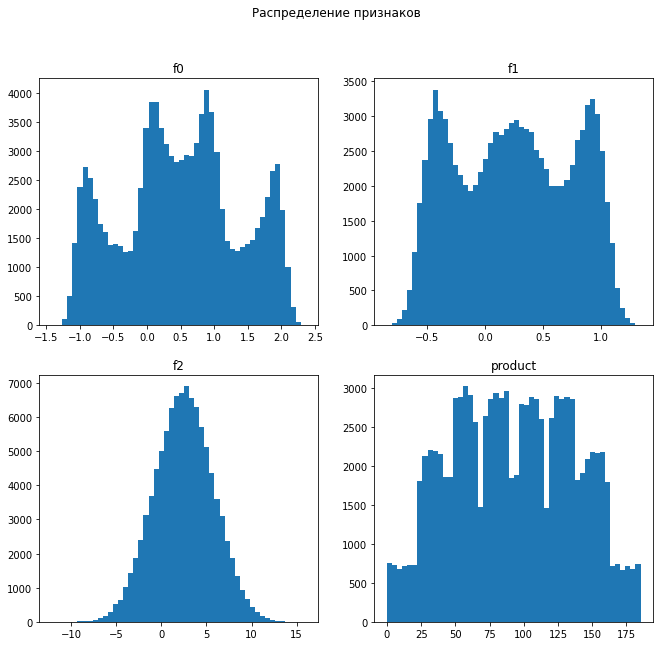

In [ ]:
draw_histplot(data_1)

Все признаки, за исключением `f2`, имеют ненормальное распределение

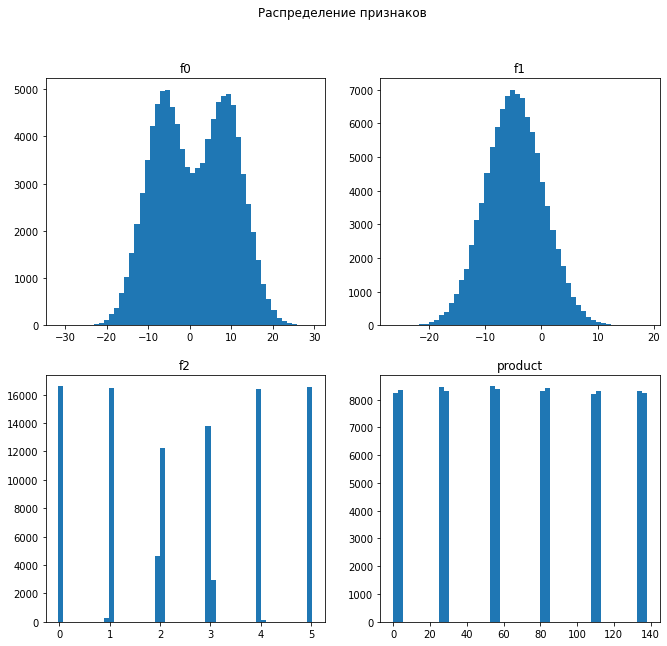

In [ ]:
draw_histplot(data_2)

Здесь ситуация похожая, но нормальное распределение имеет признак `f1`

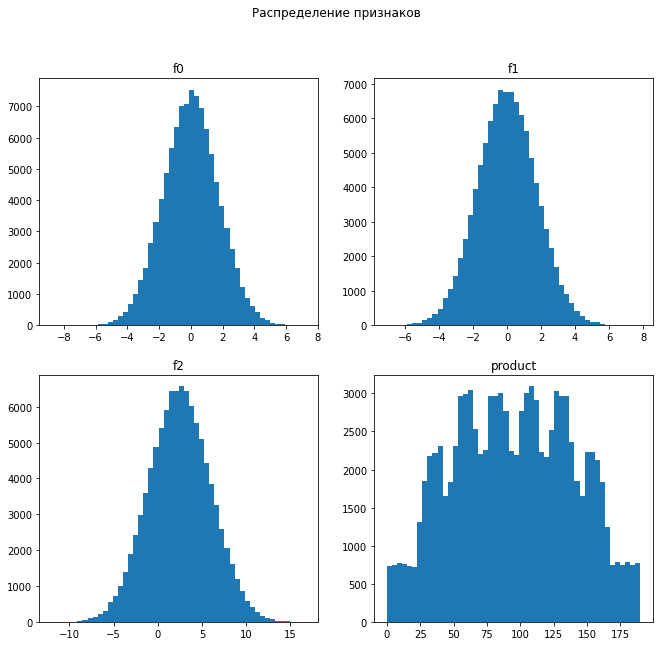

In [ ]:
draw_histplot(data_3)

И ящики с усами

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seab

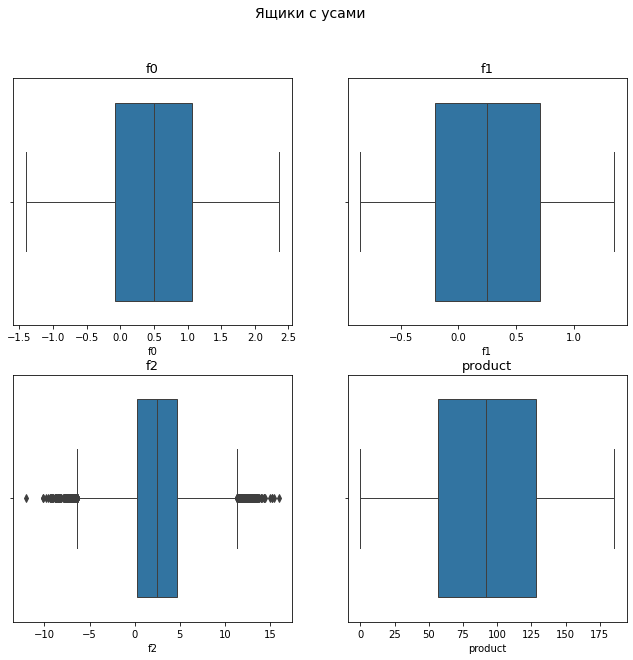

In [ ]:
draw_boxplot(data_1)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seab

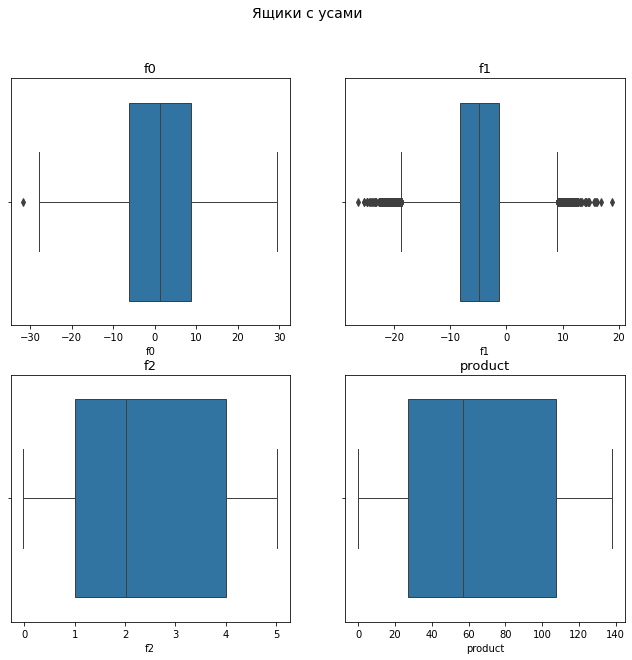

In [ ]:
draw_boxplot(data_2)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seab

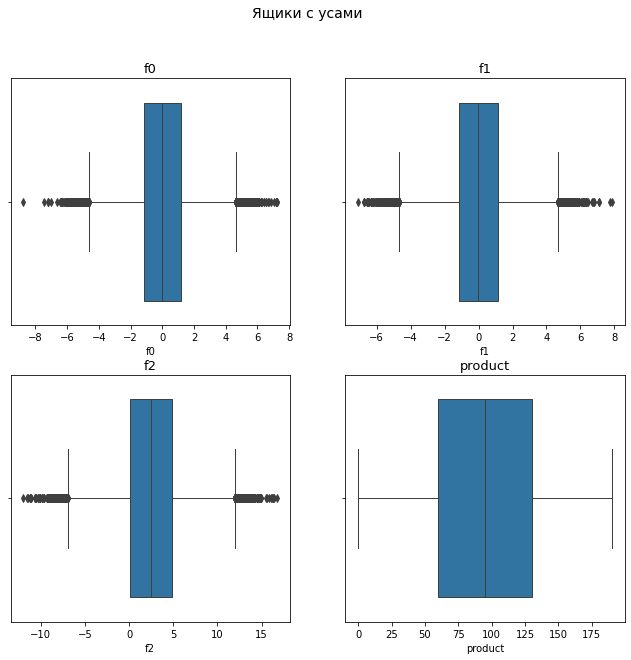

In [ ]:
draw_boxplot(data_3)

Здесь у признаков `f0`, `f1` и `f2` нормальное распределение

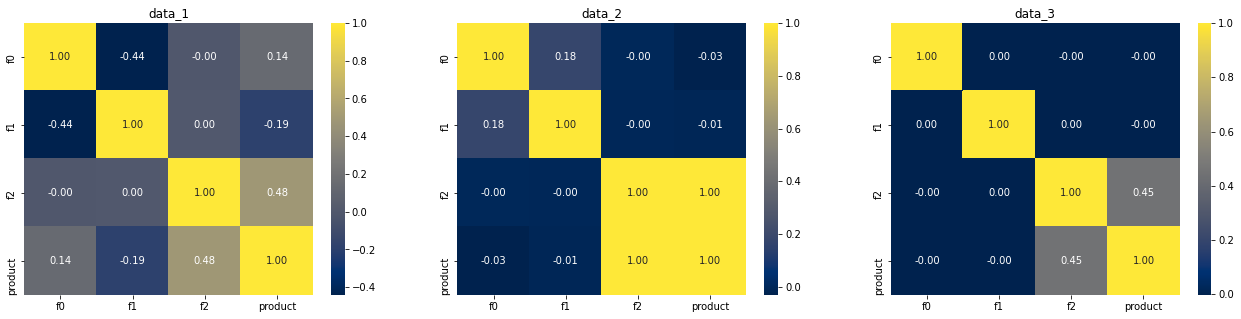

<Figure size 576x504 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
plt.figure(figsize=(8, 7))
sns.heatmap(data_1.drop('id', axis=1).corr(),
            annot=True,
            cmap='cividis',
            fmt='.2f',
            ax=axs[0])
axs[0].set_title('data_1')

sns.heatmap(data_2.drop('id', axis=1).corr(),
            annot=True,
            cmap='cividis',
            fmt='.2f',
            ax=axs[1])
axs[1].set_title('data_2')

sns.heatmap(data_3.drop('id', axis=1).corr(),
            annot=True,
            cmap='cividis',
            fmt='.2f',
            ax=axs[2])
axs[2].set_title('data_3')

plt.show()

Можно заметить мультиколлинеарность во втором датасете у признаков `f2` и `product`

# Обучение модели

In [ ]:
def linear_model(data):
    RANDOM_STATE = 42
    TEST_SIZE = 0.25

    X = data.drop(['id', 'product'], axis=1)
    y = data['product']

    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE,
        test_size=TEST_SIZE)

    num_col_names = ['f0', 'f1', 'f2']

    # Масштабируем
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_valid_scaled = scaler.transform(X_valid[num_col_names])

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_col_names)

    # Инициализируем модель линейной регрессии и обучаем ее
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
    # Наш прогноз
    predictions = model_lr.predict(X_valid)

    return y_valid, model_lr, predictions, scaler

**Первый регион**

In [ ]:
y_valid_1, model_1, predict_1, scaler_1 = linear_model(data_1)

In [ ]:
rmse_1 = mean_squared_error(y_valid_1, predict_1) ** 0.5

In [ ]:
print(f'Средний запас сырья: {round(predict_1.mean(), 2)} тыс. баррелей')
print(f'RMSE = {round(rmse_1, 2)}')

Средний запас сырья: 92.4 тыс. баррелей
RMSE = 37.76


**Второй регион**

In [ ]:
y_valid_2, model_2, predict_2, scaler_2 = linear_model(data_2)

In [ ]:
rmse_2 = mean_squared_error(y_valid_2, predict_2) ** 0.5

In [ ]:
print(f'Средний запас сырья: {round(predict_2.mean(), 2)} тыс. баррелей')
print(f'RMSE = {round(rmse_2, 2)}')

Средний запас сырья: 68.71 тыс. баррелей
RMSE = 0.89


**Третий регион**

In [ ]:
y_valid_3, model_3, predict_3, scaler_3 = linear_model(data_3)

In [ ]:
rmse_3 = mean_squared_error(y_valid_3, predict_3) ** 0.5

In [ ]:
print(f'Средний запас сырья: {round(predict_3.mean(), 2)} тыс. баррелей')
print(f'RMSE = {round(rmse_3, 2)}')

Средний запас сырья: 94.77 тыс. баррелей
RMSE = 40.15


## Выводы

1. Данные были разделены на обучающую и валидационную в соотношении 75:25;
2. Признаки были масштабированы с помощью `StandardScaler()`;
3. Результаты модели:
    - В первом регионе средний запас сырья - 92.4 тыс баррелей, RMSE = 37.76;
    - Во втором регионе средний запас сырья - 68.71 тыс. баррелей, RMSE = 0.89;
    - В третьем регионе средний запас сырья - 94.77 тыс. баррелей, RMSE = 40.15.
4. Прогноз во втором регионе прогноз вышел точный, хотя средний запас сырья меньше, чем в остальных. Первый и третий регион не особо отличается по метрике

# Расчет прибыли

In [ ]:
budget = 10000000000 # Бюджет на разработку скважин
income = 450000 # Доход с тысячи баррелей продукта
total_points = 500 # Количество исследуемых точек для разработки
best_points = 200 # Количество лучших точек для разработки

Для того, чтобы найти достаточный объём сырья для безубыточной разработки новой скважины используем формулу $$\frac{\text{Бюджет}}{\text{Количество}\space\text{скважин} × \text{Доход}\space\text{с}\space\text{единицы}\space
\text{продукта}}$$

In [ ]:
volume = budget / (income * best_points)
print(f'Достаточный объём сырья для безубыточной разработки новой скважины равен {round(volume, 2)} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины равен 111.11 тыс. баррелей


Данные по среднему запасу сырья:
- В первом регионе - 92.4 тыс баррелей;
- Во втором регионе - 68.71 тыс. баррелей;
- В третьем регионе - 94. тыс. баррелей.

Средний запас сырья в каждом регионе меньше необходимого минимума для разработки скважины. Выберем скважины с максимальным объемом сырья

# Функция для расчёта прибыли

In [ ]:
def profit(target_values, predictions):
    sorted_predict = pd.Series(predictions, index=target_values.index).sort_values(ascending=False)

    revenue = target_values[sorted_predict.index][:best_points].sum()

    return revenue * income - budget

In [ ]:
print(f'Прибыль в первом регионе: {round(profit(y_valid_1, predict_1), 1)} рублей')

Прибыль в первом регионе: 3359141114.5 рублей


In [ ]:
print(f'Прибыль во втором регионе: {round(profit(y_valid_2, predict_2), 1)} рублей')

Прибыль во втором регионе: 2415086696.7 рублей


In [ ]:
print(f'Прибыль в третьем регионе: {round(profit(y_valid_3, predict_3), 1)} рублей')

Прибыль в третьем регионе: 2598571759.4 рублей


Самая большая прибыль вышла у первого региона - 3.36 млрд рублей

# Подсчет рисков и прибыли

In [ ]:
def bootstrap_analysis(target, predict, points_development=500, best_points=200):
    samples = []
    count_loss = 0
    state = np.random.RandomState(12345)
    predict_series = pd.Series(predict, index=target.index)

    for _ in range(1000):
        target_subsample = target.sample(n=points_development, replace=True, random_state=state)
        probs_subsample = predict_series[target_subsample.index]
        samples.append(profit(target_subsample, probs_subsample))

    count_loss = sum(1 for i in samples if i < 0)

    samples = pd.Series(samples)
    mean_profit = samples.mean()

    lower_interval = samples.quantile(0.025)
    upper_interval = samples.quantile(0.975)

    print(f'Средняя прибыль в регионе равна {round(mean_profit / 1e6, 2)} млн. рублей')
    print(f'95%-й доверительный интервал: {round(lower_interval / 1e6, 2)} млн. рублей - {round(upper_interval / 1e6, 2)} млн. рублей')
    print(f'Вероятность убытка в регионе: {round((samples < 0).mean() * 100, 2)}%')


**Первый регион:**

In [ ]:
bootstrap_analysis(y_valid_1, predict_1)

Средняя прибыль в регионе равна 435.93 млн. рублей
95%-й доверительный интервал: -116.23 млн. рублей - 966.5 млн. рублей
Вероятность убытка в регионе: 6.1%


**Второй регион:**

In [ ]:
bootstrap_analysis(y_valid_2, predict_2)

Средняя прибыль в регионе равна 489.66 млн. рублей
95%-й доверительный интервал: 55.12 млн. рублей - 905.76 млн. рублей
Вероятность убытка в регионе: 1.1%


**Третий регион:**

In [ ]:
bootstrap_analysis(y_valid_3, predict_3)

Средняя прибыль в регионе равна 403.69 млн. рублей
95%-й доверительный интервал: -153.12 млн. рублей - 952.89 млн. рублей
Вероятность убытка в регионе: 7.1%


# Вывод

После применения технологии Bootstrap, мы выявили среднюю прибыль в регионе, 95%-й доверительный интервал и вероятность убытка в данном регионе.

Согласно результатам, нам подходит только второй регион для разработки 200 скважин, так как вероятность убытка здесь составляет 1.1%, а в соответствии с условиями задачи вероятность должна быть меньше 2.5%, но и доход здесь самый высокий - 490 млн. рублей

Поэтому, компании "ГлавРосГосНефть" рекомендуется строить скважины во **втором регионе**